# Testing the effect of reducing the number of task descriptions

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from llm_elicited_priors.utils import load_nested_dict_to_pandas
from llm_elicited_priors.plotting import graph_theme

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
PROMPTS_DIR = "./prompts/elicitation"
PRIORS_DIR = "./priors/elicitation/gpt-3-5-turbo-0125"
SAVE_DIR = "./results/elicitation"

In [4]:
dataset_order = [
    "fake_data",
    "uti",
    "breast_cancer",
    "california_housing",
    "wine_quality",
    "heart_disease",
]

dataset_nice_names = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "wine_quality": "Wine Quality",
    "heart_disease": "Heart Disease",
}

In [5]:
save_file = Path(SAVE_DIR).joinpath("fewer_descriptions.json")

with open(save_file, "r") as f:
    results = json.load(f)

In [6]:
results_df = load_nested_dict_to_pandas(
    results, 
    level_names=["dataset", "repeat"]
)


results_df = (
    results_df
    .melt(
        id_vars=["dataset", "repeat"], 
        var_name="n_priors", 
        value_name="energy_distance"
    )
    .astype({
        "repeat": int,
        "n_priors": int,
    })
    .assign(n_priors=lambda x: x["n_priors"]**2)
)

In [7]:
n_task_descriptions_df = (
    results_df
    .groupby(["dataset", "n_priors"])
    ["energy_distance"]
    .apply(
        lambda x: (
            f"{np.mean(x):.2f}"
            + " ± "
            f"{np.std(x):.2f}"
        )
    )
    .to_frame()
    .unstack()
    ["energy_distance"]
    .rename_axis(None, axis=1)
    .loc[dataset_order]
    .reset_index()
    .replace(
        {"dataset": dataset_nice_names}
    )
)
n_task_descriptions_df

,dataset,16,25,36,49,64,81,100
0,$y = 2 x_1 - x_2 + x_3$,0.10 ± 0.06,0.11 ± 0.07,0.07 ± 0.04,0.10 ± 0.04,0.04 ± 0.02,0.04 ± 0.02,0.01 ± 0.00
1,UTI,0.10 ± 0.03,0.07 ± 0.02,0.06 ± 0.04,0.05 ± 0.03,0.03 ± 0.01,0.02 ± 0.00,0.01 ± 0.00
2,Breast Cancer,0.25 ± 0.07,0.20 ± 0.08,0.12 ± 0.05,0.10 ± 0.04,0.06 ± 0.02,0.04 ± 0.01,0.02 ± 0.00
3,California Housing,0.11 ± 0.09,0.08 ± 0.04,0.05 ± 0.03,0.05 ± 0.02,0.04 ± 0.02,0.02 ± 0.01,0.01 ± 0.00
4,Wine Quality,0.13 ± 0.06,0.09 ± 0.04,0.07 ± 0.03,0.05 ± 0.02,0.04 ± 0.01,0.03 ± 0.01,0.02 ± 0.00
5,Heart Disease,0.12 ± 0.04,0.08 ± 0.03,0.06 ± 0.02,0.05 ± 0.02,0.04 ± 0.01,0.03 ± 0.01,0.02 ± 0.00


In [8]:
print(n_task_descriptions_df.to_latex(index=False, ))

\begin{tabular}{llllllll}
\toprule
dataset & 16 & 25 & 36 & 49 & 64 & 81 & 100 \\
\midrule
$y = 2 x_1 - x_2 + x_3$ & 0.10 ± 0.06 & 0.11 ± 0.07 & 0.07 ± 0.04 & 0.10 ± 0.04 & 0.04 ± 0.02 & 0.04 ± 0.02 & 0.01 ± 0.00 \\
UTI & 0.10 ± 0.03 & 0.07 ± 0.02 & 0.06 ± 0.04 & 0.05 ± 0.03 & 0.03 ± 0.01 & 0.02 ± 0.00 & 0.01 ± 0.00 \\
Breast Cancer & 0.25 ± 0.07 & 0.20 ± 0.08 & 0.12 ± 0.05 & 0.10 ± 0.04 & 0.06 ± 0.02 & 0.04 ± 0.01 & 0.02 ± 0.00 \\
California Housing & 0.11 ± 0.09 & 0.08 ± 0.04 & 0.05 ± 0.03 & 0.05 ± 0.02 & 0.04 ± 0.02 & 0.02 ± 0.01 & 0.01 ± 0.00 \\
Wine Quality & 0.13 ± 0.06 & 0.09 ± 0.04 & 0.07 ± 0.03 & 0.05 ± 0.02 & 0.04 ± 0.01 & 0.03 ± 0.01 & 0.02 ± 0.00 \\
Heart Disease & 0.12 ± 0.04 & 0.08 ± 0.03 & 0.06 ± 0.02 & 0.05 ± 0.02 & 0.04 ± 0.01 & 0.03 ± 0.01 & 0.02 ± 0.00 \\
\bottomrule
\end{tabular}



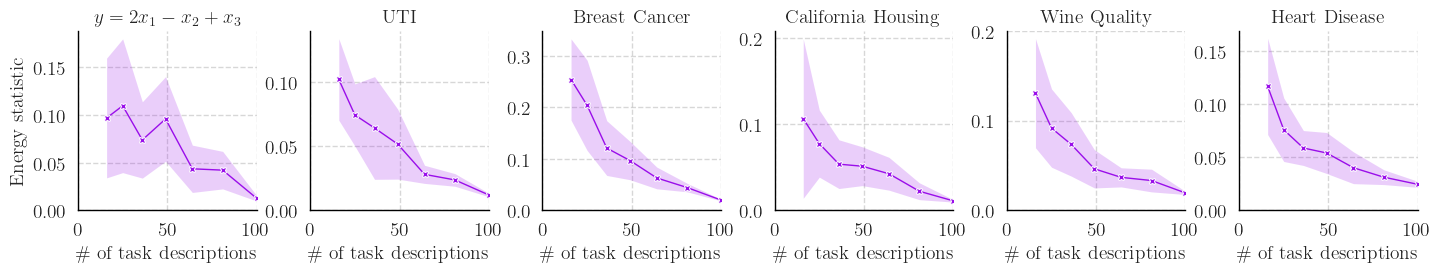

In [9]:
fontsize=14

plt.close()
with graph_theme():

    fig = plt.figure(figsize=(2*linewidth, 0.6*linewidth/1.618), )

    for i, dataset in enumerate(dataset_order):
        ax = fig.add_subplot(1, 6, i + 1)

        sns.lineplot(
            data=results_df[results_df["dataset"] == dataset],
            x="n_priors",
            y="energy_distance",
            ax=ax,
            marker="X",
            markersize=5,
            linewidth=1,
            legend=False,
            color="xkcd:violet",
            errorbar=('sd', 1),
            err_kws=dict(
                linewidth=0,
            )
        )

        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        ax.set_xlabel("\# of task descriptions", fontsize=fontsize)

        if i >0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Energy statistic", fontsize=fontsize)

        ax.set_title(dataset_nice_names[dataset], fontsize=fontsize)

        ax.set_ylim(0)
        ax.set_xlim(0, 100)
    
    fig.subplots_adjust(
        left=0.05,
        right=0.99,
        bottom=0.22,
        top=0.9,
        wspace=0.3,
    )

    plt.savefig(
        "results/effects_of_fewer_descriptions.pdf",
    )

    plt.show()